# Mask R-CNN - Inspect Pantograph Training Data

Inspect and visualize data loading and pre-processing code.

In [1]:
import os
import sys
import itertools
import math
import numpy as np
import logging
import json
import re
import random
from collections import OrderedDict
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.lines as lines
from matplotlib.patches import Polygon

# Root directory of the project
ROOT_DIR = os.path.abspath("../")

# Add root to path 
if ROOT_DIR not in sys.path:
    sys.path.append(ROOT_DIR)

# Import Mask RCNN
import mrcnn.model as modellib
from mrcnn.model import log
from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images

# Import pantogrograph class
from dev import pantograph

Using TensorFlow backend.


I've been imported


## Configurations

Configurations are defined in balloon.py

In [2]:
config = pantograph.PantographConfig()
config.display()


Configurations Superlee:
BACKBONE                       resnet101
BACKBONE_SHAPES                [[256 256]
 [128 128]
 [ 64  64]
 [ 32  32]
 [ 16  16]]
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        50
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.3
GPU_COUNT                      1
IMAGES_PER_GPU                 2
IMAGE_MAX_DIM                  1024
IMAGE_MIN_DIM                  512
IMAGE_MIN_SCALE                0.5
IMAGE_PADDING                  True
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
KEYPOINT_MASK_POOL_SIZE        7
KEYPOINT_MASK_SHAPE            [56, 56]
KEYPOINT_THRESHOLD             0.005
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.002
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES        

## Dataset

In [3]:
# Set path to root of images. 
DATA_DIR = os.path.join(ROOT_DIR, "datasets/pantograph")

# Load dataset
dataset = pantograph.PantographDataset()
dataset.load_pantograph(DATA_DIR, "train")

# Must call before using the dataset
dataset.prepare()

print("Image Count: {}".format(len(dataset.image_ids)))
print("Class Count: {}".format(dataset.num_classes))

for i, info in enumerate(dataset.class_info):
    print("{:3}. {:50}".format(i, info['name']))

loading annotations into memory...
Done (t=0.45s)
creating index...
index created!
Skeleton: (5, 2)
Keypoint names: (6,)
Image Count: 199
Class Count: 4
  0. BG                                                
  1. front_bar                                         
  2. middle_bar                                        
  3. rear_bar                                          


## Display Samples

Load and display images and masks.

In [8]:
'''
Load sample image
'''

# Set random image_id
image_id = random.choice(dataset.image_ids)

# Set specific image_id
# image_id = 5

print("image_id ", image_id, dataset.image_reference(image_id))

# Load image
image = dataset.load_image(image_id)

image_id  44 /home/jupyter/GCP_Test/datasets/pantograph/train/swin_to_padd_frame_57404.jpg


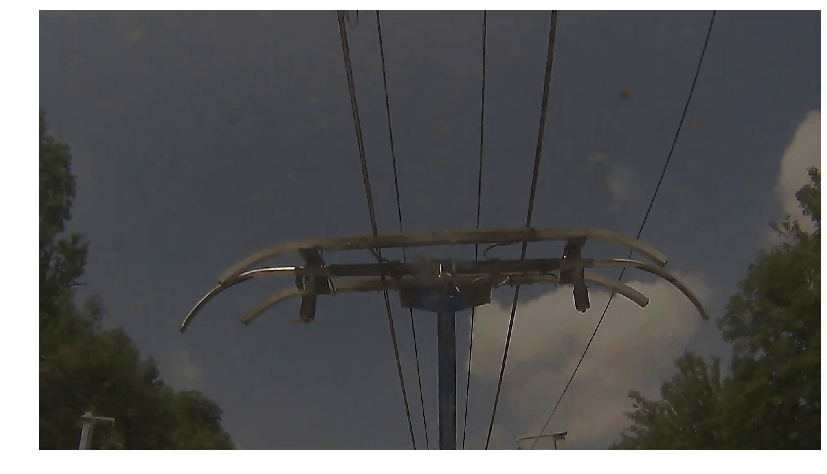

In [9]:
'''
Display image without annotation
'''

display_images([image],cols=1)

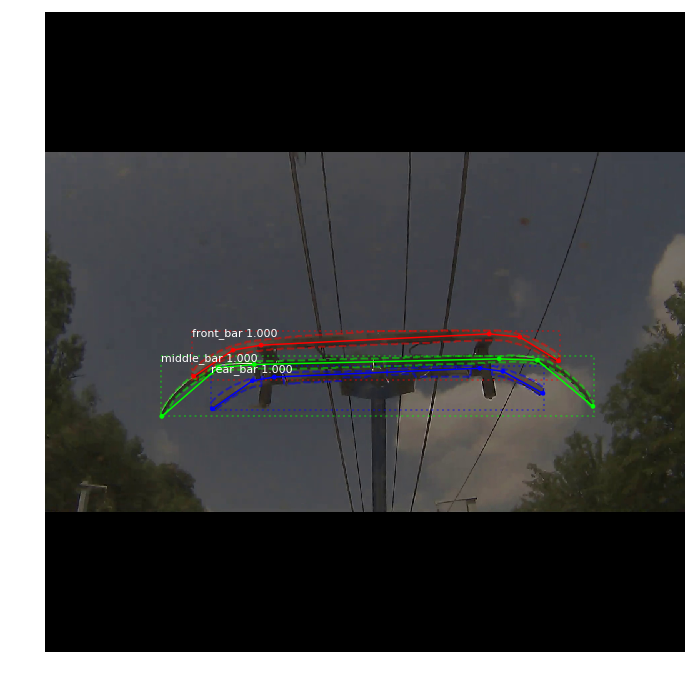

In [11]:
'''
Display ground truth image
'''

# mini mask = False
image, image_meta, class_ids, bbox, masks, keypoints =\
    modellib.load_image_gt_keypoints(dataset, config, 
                           image_id, augment=False,use_mini_mask=False)

scores = [1.0,1.0,1.0]

# How to ensure alignment/where to get classnames, colors, etc??
class_names = [dataset.class_names[1:][i-1] for i in class_ids]
 
if masks.shape[0] < 1024:
    masks = utils.expand_mask(bbox, masks, (1024,1024))

visualize.DrawAnnotations(image, class_ids,class_names,bbox=bbox,masks=masks,keypoints=keypoints,skeleton=dataset.skeleton,scores=scores,figsize=[12,12])

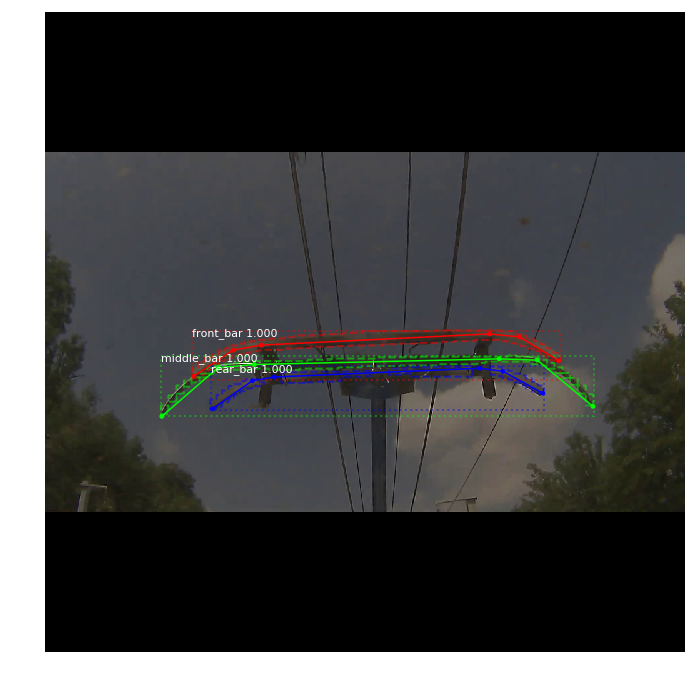

In [12]:
'''
Display image using mini mask
'''

# Mini mask = True
image, image_meta, class_ids, bbox, masks, keypoints =\
    modellib.load_image_gt_keypoints(dataset, config, 
                           image_id, augment=False,use_mini_mask=True)

scores = [1.0,1.0,1.0]

# How to ensure alignment/where to get classnames, colors, etc??
class_names = [dataset.class_names[1:][i-1] for i in class_ids]
 
if masks.shape[0] < 1024:
    masks = utils.expand_mask(bbox, masks, (1024,1024))

visualize.DrawAnnotations(image, class_ids,class_names,bbox=bbox,masks=masks,keypoints=keypoints,skeleton=dataset.skeleton,scores=scores,figsize=[12,12])

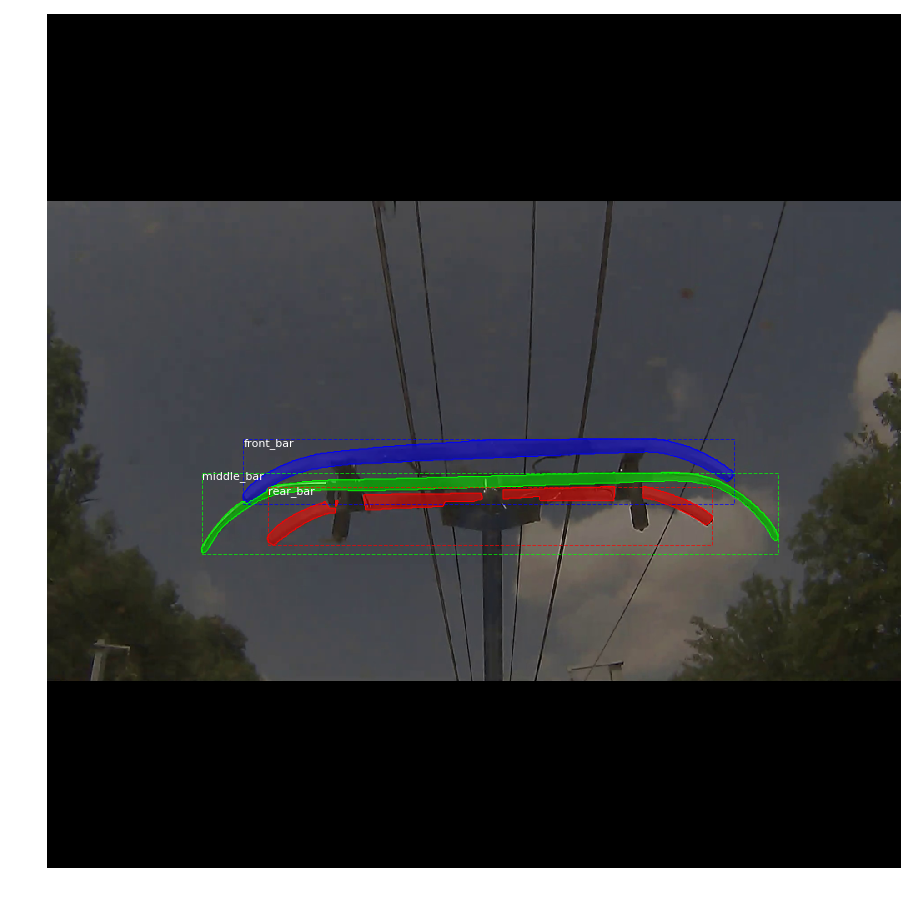

In [16]:
'''
Display instances
'''

image, image_meta, class_ids, bbox, masks, keypoints =\
    modellib.load_image_gt_keypoints(dataset, config, 
                           image_id, augment=False,use_mini_mask=False)


# Display bbox
visualize.display_instances(image, bbox, masks, class_ids, dataset.class_names)

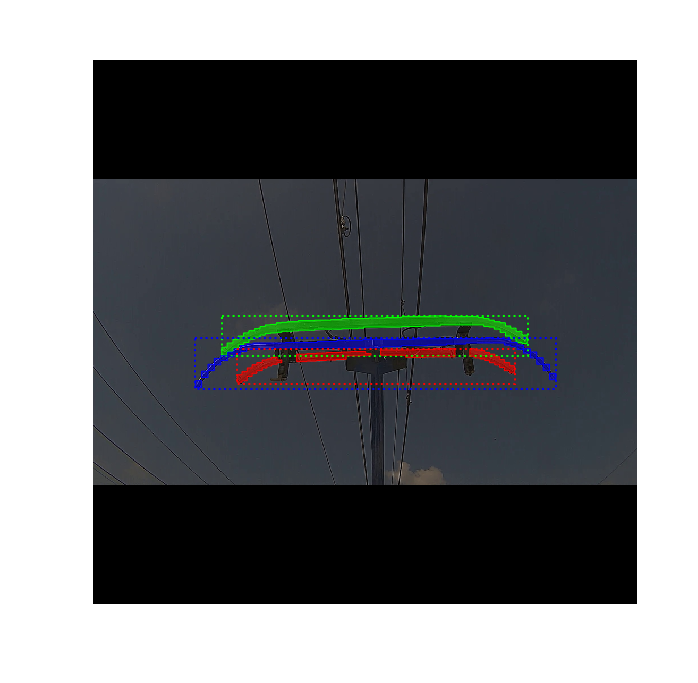

In [75]:
'''
Display boxes
'''

# Mini mask = True
image, image_meta, class_ids, bbox, masks, keypoints =\
    modellib.load_image_gt_keypoints(dataset, config, 
                           image_id, augment=False,use_mini_mask=True)

if masks.shape[0] < image.shape[0]:
    masks = utils.expand_mask(bbox, masks, image.shape)
# Display bbox

visualize.draw_boxes(image, boxes=bbox,masks=masks)

## Resize Images

To support multiple images per batch, images are resized to one size (1024x1024). Aspect ratio is preserved, though. If an image is not square, then zero padding is added at the top/bottom or right/left.

image_id:  4 /home/jupyter/GCP_Test/datasets/pantograph/train/padd_to_swin_frame_31785.jpg
Original shape:  (1080, 1920, 3)
New shape:  (1024, 1024, 3)


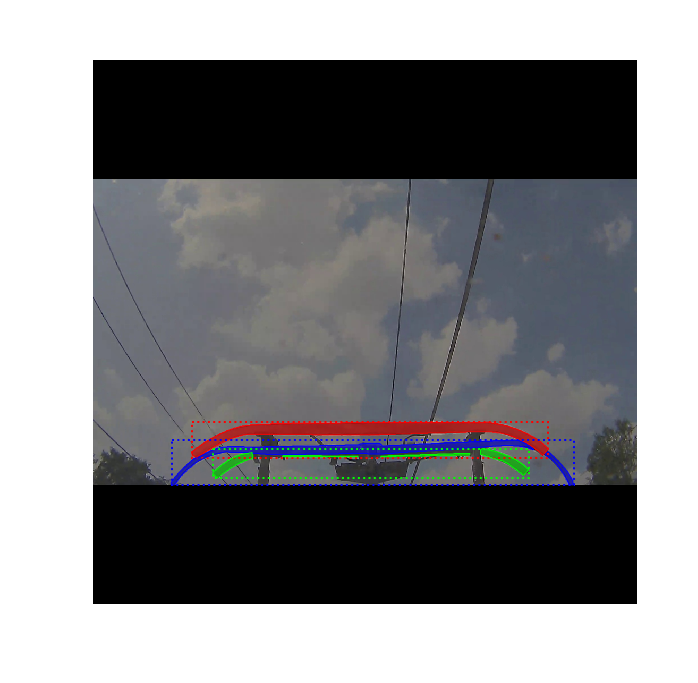

In [22]:
# Load random image and mask.
image_id = random.choice(dataset.image_ids)
image = dataset.load_image(image_id)
original_shape = image.shape

# Get data
# mask, class_ids = dataset.load_mask(image_id)
keypoints, masks, bbox, class_ids = dataset.load_keypoints(image_id)

# Resize
image, window, scale, padding, crop = utils.resize_image(
    image, 
    min_dim=config.IMAGE_MIN_DIM, 
    max_dim=config.IMAGE_MAX_DIM,
    min_scale=.5,
    padding=config.IMAGE_PADDING,
    mode='square') # config.IMAGE_RESIZE_MODE
masks = utils.resize_mask(masks, scale, padding)
newSize = (window[0]+window[2],window[1]+window[3])
keypoints = utils.resize_keypoints(keypoints, newSize, scale, padding)

# Compute resized bounding box
bbox = utils.extract_bboxes(masks)

# Display image and additional stats
print("image_id: ", image_id, dataset.image_reference(image_id))
print("Original shape: ", original_shape)
print("New shape: ", image.shape)

# visualize.DrawAnnotations(image, class_ids,class_names,bbox=bbox,masks=masks,keypoints=keypoints,skeleton=dataset.skeleton,scores=None,figsize=[12,12])
visualize.draw_boxes(image, boxes=bbox,masks=masks)

## Masks

Instance binary masks can get large when training with high resolution images. For example, if training with 1024x1024 image then the mask of a single instance requires 1MB of memory (Numpy uses bytes for boolean values). If an image has 100 instances then that's 100MB for the masks alone. 

To improve training speed, we optimize masks by:
* We store mask pixels that are inside the object bounding box, rather than a mask of the full image. Most objects are small compared to the image size, so we save space by not storing a lot of zeros around the object.
* We resize the mask to a smaller size (e.g. 56x56). For objects that are larger than the selected size we lose a bit of accuracy. But most object annotations are not very accuracy to begin with, so this loss is negligable for most practical purposes. Thie size of the mini_mask can be set in the config class.

To visualize the effect of mask resizing, and to verify the code correctness, we visualize some examples.

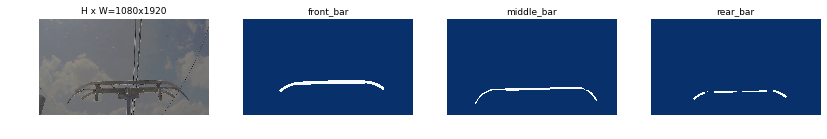

In [85]:
'''
Display Top Mask
'''

# Load random image and mask.
image_id = random.choice(dataset.image_ids)
image = dataset.load_image(image_id)

masks, class_ids = dataset.load_mask(image_id)

visualize.display_top_masks(image, masks, class_ids, dataset.class_names,limit=3)

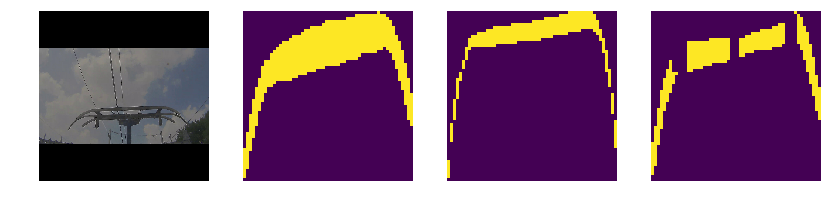

In [86]:
'''
Display Mini Mask
'''

image_id = np.random.choice(dataset.image_ids, 1)[0]

image, image_meta, class_ids, bbox, masks, keypoints =\
    modellib.load_image_gt_keypoints(dataset, config, 
                           image_id, augment=False,use_mini_mask=True)

display_images([image]+[masks[:,:,i] for i in range(min(masks.shape[-1], 7))])

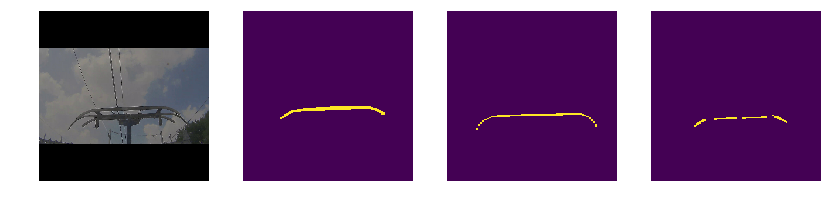

In [87]:
'''
Resize Mini Mask to image size
'''

masks = utils.expand_mask( bbox, masks, image.shape)
display_images([image]+[masks[:,:,i] for i in range(min(masks.shape[-1], 7))])

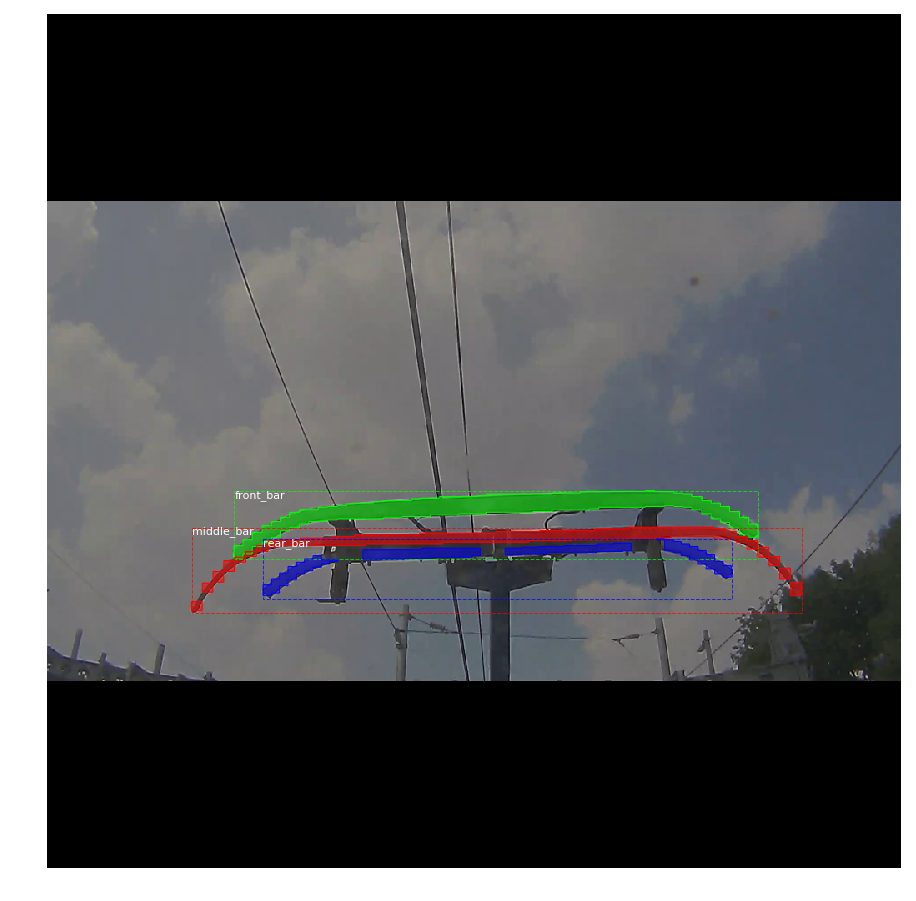

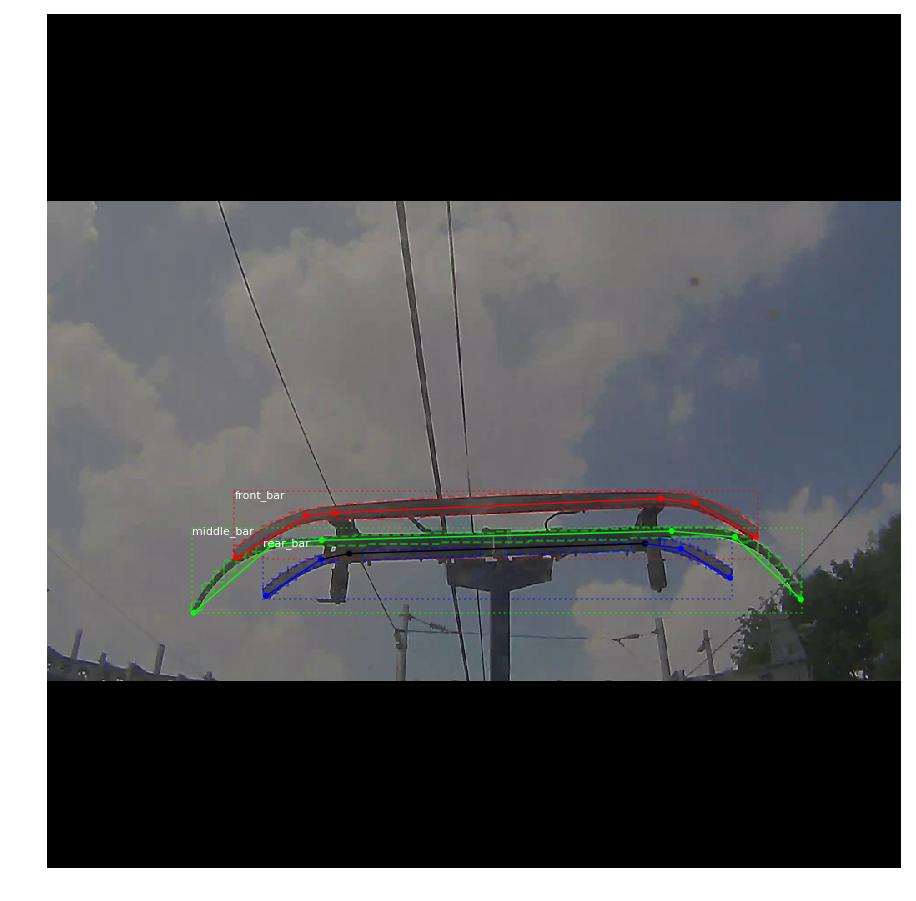

In [93]:
'''
Resize Mini Mask to image size
'''

visualize.display_instances(image, bbox, masks, class_ids, dataset.class_names)

visualize.DrawAnnotations(image, class_ids,class_names,bbox=bbox,masks=masks,keypoints=keypoints,skeleton=dataset.skeleton,scores=None,figsize=[16,16])

## Augmentation

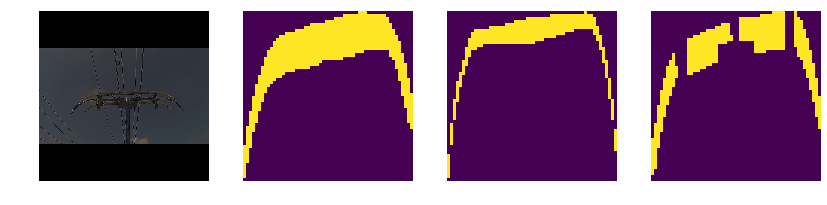

In [72]:
# Add augmentation and mask resizing.
image, image_meta, class_ids, bbox, mask = modellib.load_image_gt(
    dataset, config, image_id, augment=True, use_mini_mask=True)


display_images([image]+[mask[:,:,i] for i in range(min(mask.shape[-1], 7))])

## Anchors

The order of anchors is important. Use the same order in training and prediction phases. And it must match the order of the convolution execution.

For an FPN network, the anchors must be ordered in a way that makes it easy to match anchors to the output of the convolution layers that predict anchor scores and shifts. 
* Sort by pyramid level first. All anchors of the first level, then all of the second and so on. This makes it easier to separate anchors by level.
* Within each level, sort anchors by feature map processing sequence. Typically, a convolution layer processes a feature map starting from top-left and moving right row by row. 
* For each feature map cell, pick any sorting order for the anchors of different ratios. Here we match the order of ratios passed to the function.

**Anchor Stride:**
In the FPN architecture, feature maps at the first few layers are high resolution. For example, if the input image is 1024x1024 then the feature meap of the first layer is 256x256, which generates about 200K anchors (256*256*3). These anchors are 32x32 pixels and their stride relative to image pixels is 4 pixels, so there is a lot of overlap. We can reduce the load significantly if we generate anchors for every other cell in the feature map. A stride of 2 will cut the number of anchors by 4, for example. 

In this implementation we use an anchor stride of 2, which is different from the paper.

In [94]:
# Generate Anchors
backbone_shapes = modellib.compute_backbone_shapes(config, config.IMAGE_SHAPE)
anchors = utils.generate_pyramid_anchors(config.RPN_ANCHOR_SCALES, 
                                          config.RPN_ANCHOR_RATIOS,
                                          backbone_shapes,
                                          config.BACKBONE_STRIDES, 
                                          config.RPN_ANCHOR_STRIDE)

# Print summary of anchors
num_levels = len(backbone_shapes)
anchors_per_cell = len(config.RPN_ANCHOR_RATIOS)
print("Count: ", anchors.shape[0])
print("Scales: ", config.RPN_ANCHOR_SCALES)
print("ratios: ", config.RPN_ANCHOR_RATIOS)
print("Anchors per Cell: ", anchors_per_cell)
print("Levels: ", num_levels)
anchors_per_level = []
for l in range(num_levels):
    num_cells = backbone_shapes[l][0] * backbone_shapes[l][1]
    anchors_per_level.append(anchors_per_cell * num_cells // config.RPN_ANCHOR_STRIDE**2)
    print("Anchors in Level {}: {}".format(l, anchors_per_level[l]))

Count:  65472
Scales:  (32, 64, 128, 256, 512)
ratios:  [0.5, 1, 2]
Anchors per Cell:  3
Levels:  5
Anchors in Level 0: 49152
Anchors in Level 1: 12288
Anchors in Level 2: 3072
Anchors in Level 3: 768
Anchors in Level 4: 192


Level 0. Anchors:  49152  Feature map Shape: [256 256]
Level 1. Anchors:  12288  Feature map Shape: [128 128]
Level 2. Anchors:   3072  Feature map Shape: [64 64]
Level 3. Anchors:    768  Feature map Shape: [32 32]
Level 4. Anchors:    192  Feature map Shape: [16 16]


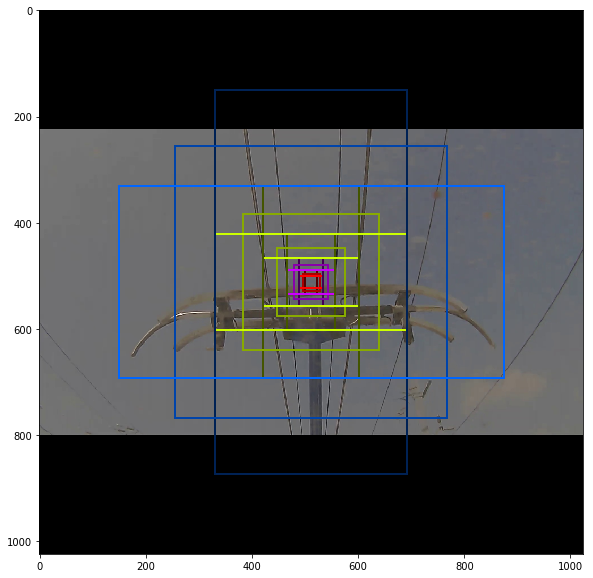

In [95]:
## Visualize anchors of one cell at the center of the feature map of a specific level

# Load and draw random image
image_id = np.random.choice(dataset.image_ids, 1)[0]
image, image_meta, _, _, _ = modellib.load_image_gt(dataset, config, image_id)
fig, ax = plt.subplots(1, figsize=(10, 10))
ax.imshow(image)
levels = len(backbone_shapes)

for level in range(levels):
    colors = visualize.random_colors(levels)
    # Compute the index of the anchors at the center of the image
    level_start = sum(anchors_per_level[:level]) # sum of anchors of previous levels
    level_anchors = anchors[level_start:level_start+anchors_per_level[level]]
    print("Level {}. Anchors: {:6}  Feature map Shape: {}".format(level, level_anchors.shape[0], 
                                                                  backbone_shapes[level]))
    center_cell = backbone_shapes[level] // 2
    center_cell_index = (center_cell[0] * backbone_shapes[level][1] + center_cell[1])
    level_center = center_cell_index * anchors_per_cell 
    center_anchor = anchors_per_cell * (
        (center_cell[0] * backbone_shapes[level][1] / config.RPN_ANCHOR_STRIDE**2) \
        + center_cell[1] / config.RPN_ANCHOR_STRIDE)
    level_center = int(center_anchor)

    # Draw anchors. Brightness show the order in the array, dark to bright.
    for i, rect in enumerate(level_anchors[level_center:level_center+anchors_per_cell]):
        y1, x1, y2, x2 = rect
        p = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=2, facecolor='none',
                              edgecolor=(i+1)*np.array(colors[level]) / anchors_per_cell)
        ax.add_patch(p)


## Data Generator


In [96]:
# Create data generator
random_rois = 2000
g = modellib.data_generator_keypoint(dataset, config, shuffle=True, augment=False, 
                                     random_rois=random_rois,
                                     batch_size=4,
                                     detection_targets=True)

In [97]:
# Get Next Image
if random_rois:
    # inputs and outputs.
    [normalized_images, image_meta, rpn_match, rpn_bbox, gt_class_ids, gt_boxes, gt_keypoints, gt_masks, rpn_rois, rois], \
    [mrcnn_class_ids, mrcnn_bbox, mrcnn_mask] = next(g)
else:
    [normalized_images, image_meta, rpn_match, rpn_bbox, gt_boxes, gt_masks], _ = next(g)
    
image_id = modellib.parse_image_meta(image_meta)["image_id"][0]
print("image_id: ", image_id, dataset.image_reference(image_id))

# Remove the last dim in mrcnn_class_ids. It's only added
# to satisfy Keras restriction on target shape.
mrcnn_class_ids = mrcnn_class_ids[:,:,0]

image_id:  113 /home/jupyter/GCP_Test/datasets/pantograph/train/swin_to_padd_frame_64776.jpg


Positive anchors: 3
Negative anchors: 147
Neutral anchors: 65322
BG                     : 67
front_bar              : 10
middle_bar             : 17
rear_bar               : 6


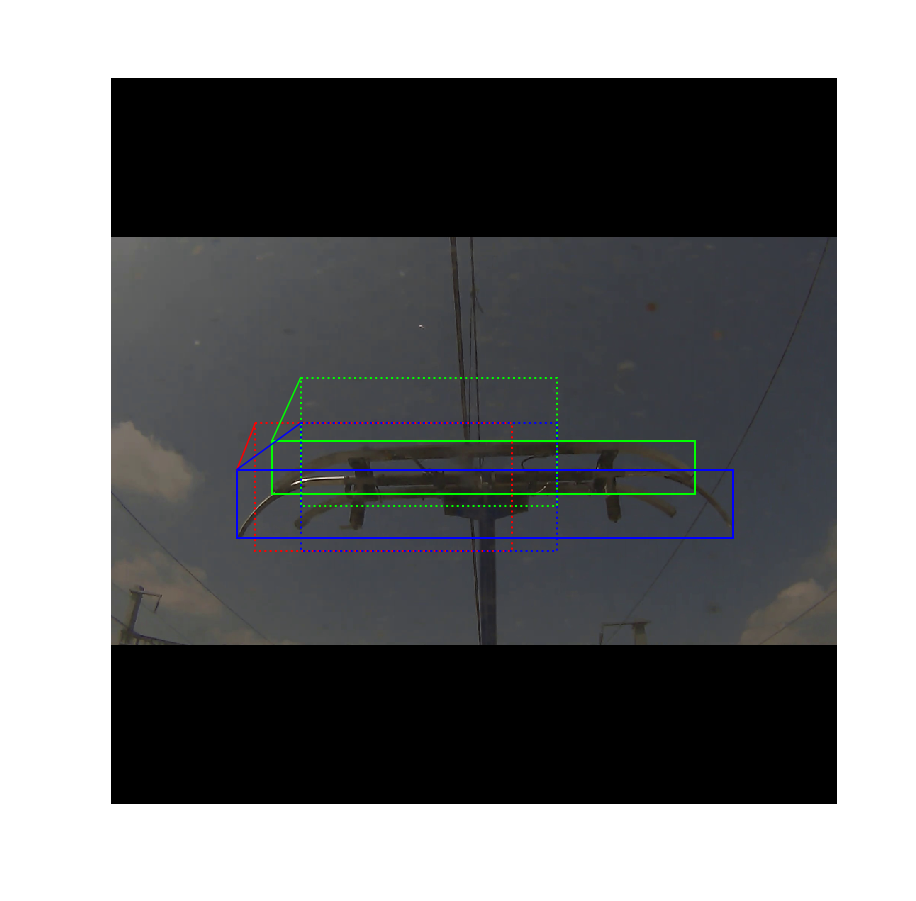

In [102]:
b = 0

# Restore original image (reverse normalization)
sample_image = modellib.unmold_image(normalized_images[b], config)

# Compute anchor shifts.
indices = np.where(rpn_match[b] == 1)[0]
refined_anchors = utils.apply_box_deltas(anchors[indices], rpn_bbox[b, :len(indices)] * config.RPN_BBOX_STD_DEV)


# Get list of positive anchors
positive_anchor_ids = np.where(rpn_match[b] == 1)[0]
print("Positive anchors: {}".format(len(positive_anchor_ids)))
negative_anchor_ids = np.where(rpn_match[b] == -1)[0]
print("Negative anchors: {}".format(len(negative_anchor_ids)))
neutral_anchor_ids = np.where(rpn_match[b] == 0)[0]
print("Neutral anchors: {}".format(len(neutral_anchor_ids)))

# ROI breakdown by class
for c, n in zip(dataset.class_names, np.bincount(mrcnn_class_ids[b].flatten())):
    if n:
        print("{:23}: {}".format(c[:20], n))

# Show positive anchors
fig, ax = plt.subplots(1, figsize=(16, 16))
visualize.draw_boxes(sample_image, boxes=anchors[positive_anchor_ids], 
                     refined_boxes=refined_anchors, ax=ax) # refined_anchors

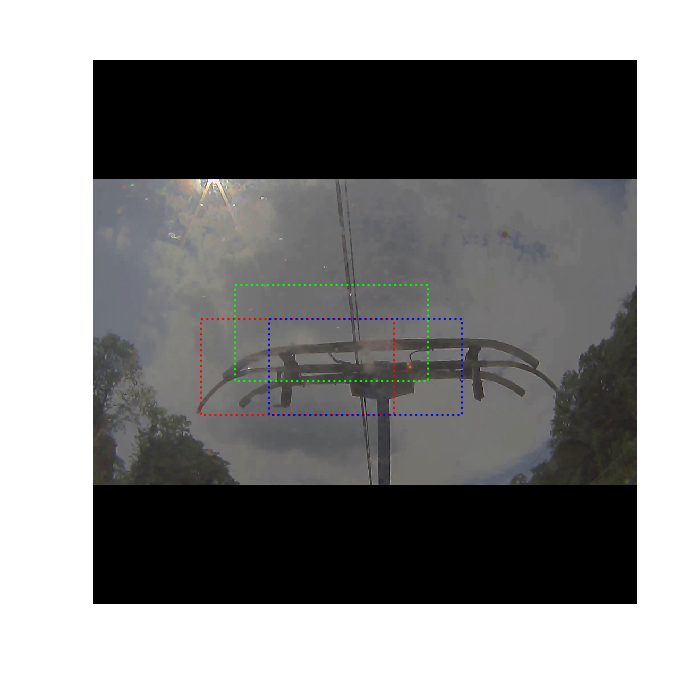

In [63]:
visualize.draw_boxes(sample_image, boxes=anchors[positive_anchor_ids])

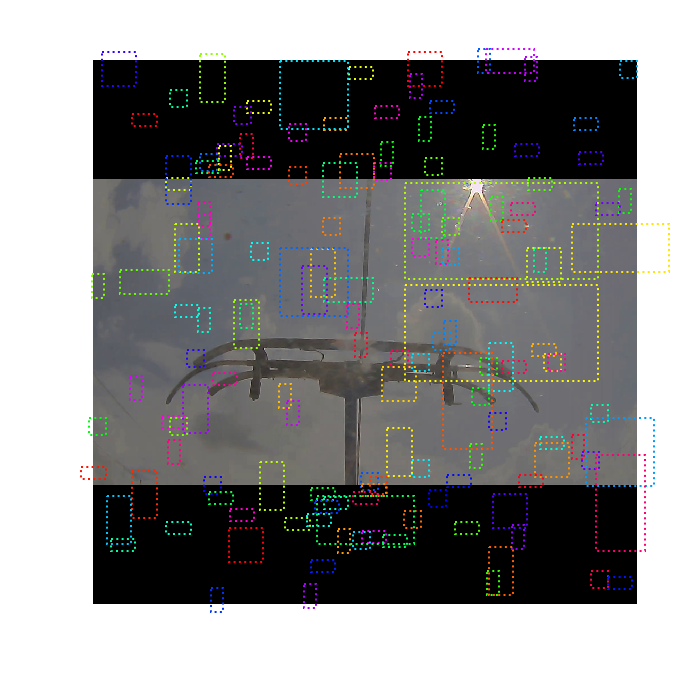

In [37]:
# Show negative anchors
visualize.draw_boxes(sample_image, boxes=anchors[negative_anchor_ids])

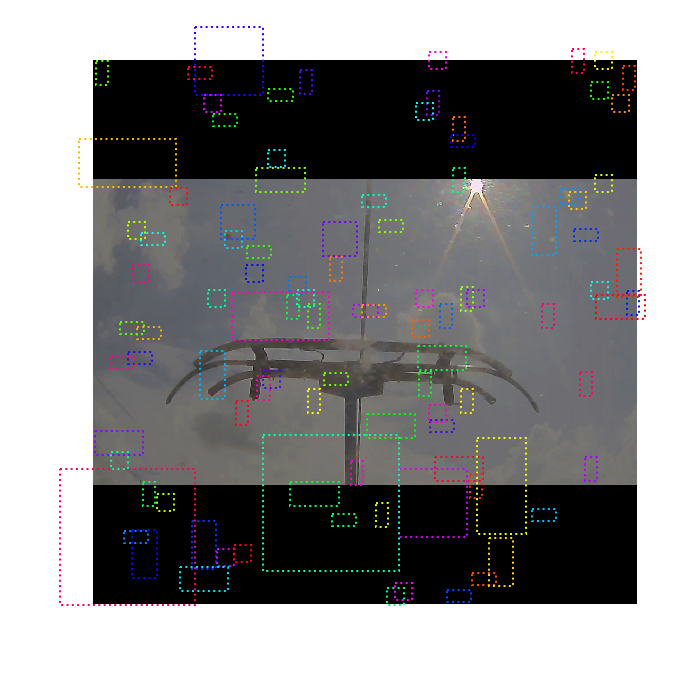

In [38]:
# Show neutral anchors. They don't contribute to training.
visualize.draw_boxes(sample_image, boxes=anchors[np.random.choice(neutral_anchor_ids, 100)])

## ROIs

Positive ROIs:  33
Negative ROIs:  67
Positive Ratio: 0.33
Unique ROIs: 100 out of 100


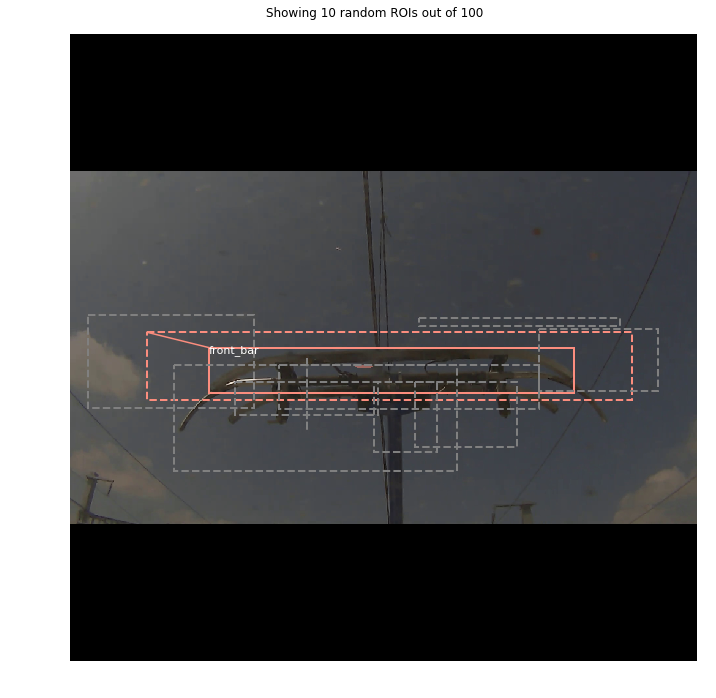

In [103]:
if random_rois:
    # Class aware bboxes
    bbox_specific = mrcnn_bbox[b, np.arange(mrcnn_bbox.shape[1]), mrcnn_class_ids[b], :]

    # Refined ROIs
    refined_rois = utils.apply_box_deltas(rois[b].astype(np.float32), bbox_specific[:,:4] * config.BBOX_STD_DEV)

    # Class aware masks
    mask_specific = mrcnn_mask[b, np.arange(mrcnn_mask.shape[1]), :, :, mrcnn_class_ids[b]]

    visualize.draw_rois(sample_image, rois[b], refined_rois, mask_specific, mrcnn_class_ids[b], dataset.class_names)
    
    # Any repeated ROIs?
    rows = np.ascontiguousarray(rois[b]).view(np.dtype((np.void, rois.dtype.itemsize * rois.shape[-1])))
    _, idx = np.unique(rows, return_index=True)
    print("Unique ROIs: {} out of {}".format(len(idx), rois.shape[1]))

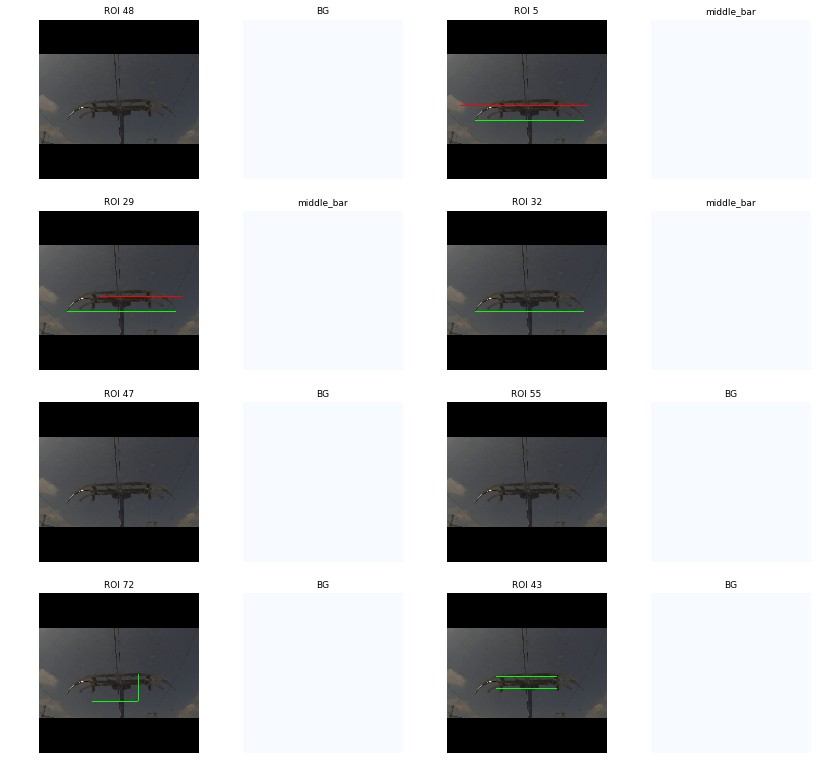

In [104]:
if random_rois:
    # Dispalay ROIs and corresponding masks and bounding boxes
    ids = random.sample(range(rois.shape[1]), 8)

    images = []
    titles = []
    for i in ids:
        image = visualize.draw_box(sample_image.copy(), rois[b,i,:4].astype(np.int32), [255, 0, 0])
        image = visualize.draw_box(image, refined_rois[i].astype(np.int64), [0, 255, 0])
        images.append(image)
        titles.append("ROI {}".format(i))
        images.append(mask_specific[i] * 255)
        titles.append(dataset.class_names[mrcnn_class_ids[b,i]][:20])

    display_images(images, titles, cols=4, cmap="Blues", interpolation="none")

In [42]:
# Check ratio of positive ROIs in a set of images.
if random_rois:
    limit = 10
    temp_g = modellib.data_generator(
        dataset, config, shuffle=True, random_rois=10000, 
        batch_size=1, detection_targets=True)
    total = 0
    for i in range(limit):
        _, [ids, _, _] = next(temp_g)
        positive_rois = np.sum(ids[0] > 0)
        total += positive_rois
        print("{:5} {:5.2f}".format(positive_rois, positive_rois/ids.shape[1]))
    print("Average percent: {:.2f}".format(total/(limit*ids.shape[1])))

   33  0.33
   33  0.33
   33  0.33
   33  0.33
   33  0.33
   33  0.33
   33  0.33
   33  0.33
   33  0.33
   33  0.33
Average percent: 0.33


## 1.2 Inspect the DetectionKeypointTargetLayer
This layers generated the ground truth keypoint labels and their values are between[0, 56*56).
Here we run a sub graph to generated the ground truth target and visulize them to check it.

In [ ]:

# rois, target_class_ids, target_bbox, target_keypoint, target_keypoint_weight, target_mask
train_keypoint_generator = modellib.data_generator_keypoint(train_dataset_keypoints, config, shuffle=True,
                                         batch_size=config.BATCH_SIZE)

#python 3.* use nexy(generator)
inputs,_ = next(train_keypoint_generator)
batch_images, batch_image_meta, batch_rpn_match, batch_rpn_bbox, batch_gt_class_ids, \
            batch_gt_boxes, batch_gt_keypoints,batch_gt_masks  = inputs


rpn = model.run_graph(inputs, [
    ("rois", model.keras_model.get_layer("proposal_targets").output[0]),
    ("target_class_ids", model.keras_model.get_layer("proposal_targets").output[1]),
    ("target_bbox", model.keras_model.get_layer("proposal_targets").output[2]),
    ("target_keypoint_lables", model.keras_model.get_layer("proposal_targets").output[3]),
    ("target_keypoint_weights", model.keras_model.get_layer("proposal_targets").output[4]),
    ("target_mask", model.keras_model.get_layer("proposal_targets").output[5]),
])

roi = rpn["rois"]
target_class_ids = rpn["target_class_ids"]
target_bbox = rpn["target_bbox"]
target_keypoint_label = rpn["target_keypoint_lables"]
target_keypoint_weight = rpn["target_keypoint_weights"]
target_mask = rpn["target_mask"]

# gt_keypoints = rpn["gt_keypoints"]
keypoint_scales = [config.IMAGE_SHAPE[1],config.IMAGE_SHAPE[0],1]
# gt_keypoints = keypoint_scales*gt_keypoints
for i in range(config.BATCH_SIZE):
    batch_orignal_image = modellib.unmold_image(batch_images[i],config)
    visualize.display_image_keypoint_mask(batch_orignal_image,roi[i],target_keypoint_label[i],target_keypoint_weight[i],
                                          target_class_ids[i],train_dataset_keypoints.class_names,config=config,iskeypointlabel= True)



### Testing Area

In [ ]:

def mold_image(images, config):
    """Takes RGB images with 0-255 values and subtraces
    the mean pixel and converts it to float. Expects image
    colors in RGB order.
    """
    return images.astype(np.float32) - config.MEAN_PIXEL

def compose_image_meta(image_id, image_shape, window, active_class_ids):
    """Takes attributes of an image and puts them in one 1D array.

    image_id: An int ID of the image. Useful for debugging.
    image_shape: [height, width, channels]
    window: (y1, x1, y2, x2) in pixels. The area of the image where the real
            image is (excluding the padding)
    active_class_ids: List of class_ids available in the dataset from which
        the image came. Useful if training on images from multiple datasets
        where not all classes are present in all datasets.
    """
    meta = np.array(
        [image_id] +            # size=1
        list(image_shape) +     # size=3
        list(window) +          # size=4 (y1, x1, y2, x2) in image cooredinates
        list(active_class_ids)  # size=num_classes
    )
    return meta



# display_images([image],cols=1)
def mold_inputs(images):
    molded_images = []
    image_metas = []
    windows = []
    for image in images:
        # Resize image to fit the model expected size
        # TODO: move resizing to mold_image()
        molded_image, window, scale, padding,crop = utils.resize_image(
            image,
            min_dim=config.IMAGE_MIN_DIM,
            max_dim=config.IMAGE_MAX_DIM,
            padding=config.IMAGE_PADDING)

        molded_image = mold_image(molded_image, config)

        # Build image_meta
        image_meta = compose_image_meta(
            0, image.shape, window,
            np.zeros([config.NUM_CLASSES], dtype=np.int32))

        # Append
        molded_images.append(molded_image)
        windows.append(window)
        image_metas.append(image_meta)

        # Pack into arrays
    molded_images = np.stack(molded_images)
    image_metas = np.stack(image_metas)
    windows = np.stack(windows)

    print(image_metas)
    print('windows',windows)
    print('scale',scale)
    print('padding',padding)
    print('crop',crop)
    
    return molded_images, image_metas, windows

In [ ]:
image_id = random.choice(dataset.image_ids)
print("image_id ", image_id, dataset.image_reference(image_id))

# image = dataset.load_image(image_id)
# display_images([image],cols=1)

image, image_meta, class_ids, bbox, masks, keypoints =\
    modellib.load_image_gt_keypoints(dataset, config, 
                           image_id, augment=False,use_mini_mask=config.USE_MINI_MASK)

molded_images, image_metas, windows = mold_inputs([image])

display_images(molded_images,cols=1)

In [ ]:
from PIL import Image
from skimage.measure import find_contours
def new_minimize_mask(bbox, mask, mini_shape):
    
    """Resize masks to a smaller version to cut memory load.
    Mini-masks can then resized back to image scale using expand_masks()

    See inspect_data.ipynb notebook for more details.
    """
#     print('Starting ,minimize mask shape:',mask.shape)
#     print(masks[0])
    mini_mask = np.zeros(mini_shape + (mask.shape[-1],), dtype=bool) #np.uint8
#     print('mini mask shape',mini_mask.shape)
    for i in range(mask.shape[-1]):
        m = mask[:, :, i]

        y1, x1, y2, x2 = bbox[i][:4]
        m = m[y1:y2, x1:x2]
#         print('m shape into image',m.shape)
#         print(m[0])
        if m.size == 0:
            raise Exception("Invalid bounding box with area of zero")


        m = np.array(Image.fromarray(m).resize((mini_shape[1],mini_shape[0])))
#         print('new m shape',m.shape)

        # ? Set mini mask to 1 where m is = 1
        mini_mask[:, :, i] = np.where(m >= 1, 1, 0)
    return mini_mask


def new_expand_mask(bbox, mini_mask, image_shape):
    """Resizes mini masks back to image size. Reverses the change
    of minimize_mask().

    See inspect_data.ipynb notebook for more details.
    """
#     print('Starting expand image mini mask shape:',mini_mask.shape)
    mask = np.zeros(image_shape[:2] + (mini_mask.shape[-1],), dtype=bool)
#     print('mask shape:',mask.shape)
    for i in range(mask.shape[-1]):
        m = mini_mask[:, :, i]
#         print('m shape into image:',m.shape)
#         print(m[0])
        y1, x1, y2, x2 = bbox[i][:4]
        h = y2 - y1
        w = x2 - x1
#         print('h:',h)
#         print('w:',w)
        
        m = np.array(Image.fromarray(m).resize((w, h)))
#         print('new m shape:',m.shape)
        mask[y1:y2, x1:x2, i] = np.where(m >= 1, 1, 0)

    return mask